# Advanced Business Analytics Capstone

## Module 2 - Part 1 : Perform predictive analysis tasks (logistic regression, classification tree, neural network)

In [23]:
#Import librairies
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

import pandas as pd

In [24]:
#Download file Lending_Club.csv
lclub = pd.read_csv("Lending_Club.csv", sep = ";")

'''
See Module 1 for complete cleaning and preparing procedure

'''

#Remove unnecessary columns
lclub = lclub.drop(columns=['id', 'member_id'])

#Fix incorrect data types for numerical columns ('int_rate', 'installment', 'annual_inc', 'total_pymnt', 'revol_util')
num_cols_to_fix = ['int_rate', 'installment', 'annual_inc', 'total_pymnt', 'revol_util']

for col in num_cols_to_fix:
    # Convert values to string for cleaning
    lclub[col] = lclub[col].astype(str)

    # Remove common non-numeric characters (% $ ,) and strip whitespace
    lclub[col] = (lclub[col]
                  .str.replace('%', '', regex=False)
                  .str.replace('$', '', regex=False)
                  .str.replace(',', '.', regex=False)
                  .str.strip())

    # Convert cleaned strings to numeric (float), coercing errors to NaN
    lclub[col] = pd.to_numeric(lclub[col], errors='coerce')

In [25]:
#Remove unnecessary columns
lclub = lclub.drop(columns=['term', 'purpose'])

# Filter to keep only the two target classes of interest, then binary encoding
lclub = lclub[lclub['loan_status'].isin(['Fully Paid', 'Charged Off'])]
lclub['loan_status'] = lclub['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

#Encode categorical variables using one-hot encoding (more than 2 categories)
cat_cols = ['home_ownership', 'verification_status']
lclub = pd.get_dummies(lclub, columns = cat_cols, drop_first = True)

In [26]:
#Manage missing values
lclub = lclub.dropna(subset=['revol_util'])

In [27]:
#Import library
import numpy as np

# Define columns and their respective winsorization percentiles
cols_1_99 = ['int_rate', 'installment', 'total_pymnt']
col_5_95 = 'annual_inc'

# Winsorize columns at 1st and 99th percentiles
for col in cols_1_99:
    lower = lclub[col].quantile(0.01)
    upper = lclub[col].quantile(0.99)
    lclub[col] = np.clip(lclub[col], lower, upper)

# Winsorize annual_inc at 5th and 95th percentiles
lower_ai = lclub[col_5_95].quantile(0.05)
upper_ai = lclub[col_5_95].quantile(0.95)
lclub[col_5_95] = np.clip(lclub[col_5_95], lower_ai, upper_ai)

In [28]:
#Import librairies
from sklearn.preprocessing import StandardScaler

#Initialize the scaler
scaler = StandardScaler()

#Columns to standardize (all winsorized columns)
cols_to_standardize = cols_1_99 + [col_5_95]

#Standardize in place in the original DataFrame
lclub[cols_to_standardize] = scaler.fit_transform(lclub[cols_to_standardize])

## Part 1 - Logistic Regression Model

In [29]:
#Import librairies
from sklearn.model_selection import train_test_split

#Features (exclude total_pymnt and loan_status)
X = lclub.drop(columns = ['loan_status', 'total_pymnt'])
y = lclub['loan_status']

In [30]:
#Check the distribution of y
y.value_counts()

loan_status
0    5941
1    1207
Name: count, dtype: int64

In [31]:
#Convert boolean columns to integer before training
bool_cols = ['home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified']
lclub[bool_cols] = lclub[bool_cols].astype(int)

#Validate
lclub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7148 entries, 0 to 7150
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_status                          7148 non-null   int64  
 1   loan_amnt                            7148 non-null   int64  
 2   int_rate                             7148 non-null   float64
 3   installment                          7148 non-null   float64
 4   annual_inc                           7148 non-null   float64
 5   revol_bal                            7148 non-null   int64  
 6   revol_util                           7148 non-null   float64
 7   total_acc                            7148 non-null   int64  
 8   acc_open_past_24mths                 7148 non-null   int64  
 9   total_pymnt                          7148 non-null   float64
 10  home_ownership_OWN                   7148 non-null   int32  
 11  home_ownership_RENT                

In [32]:
#Split set 60-40 (stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 12345, stratify = y)

In [43]:
#Import librairies
from sklearn.linear_model import LogisticRegression

#Initialize
logreg = LogisticRegression(max_iter = 1000, solver = 'liblinear', random_state = 12345, class_weight = 'balanced')

#Fit the model on the training data
logreg.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Convert probabilities to predicted classes
y_pred = (y_pred_prob >= 0.5).astype(int)

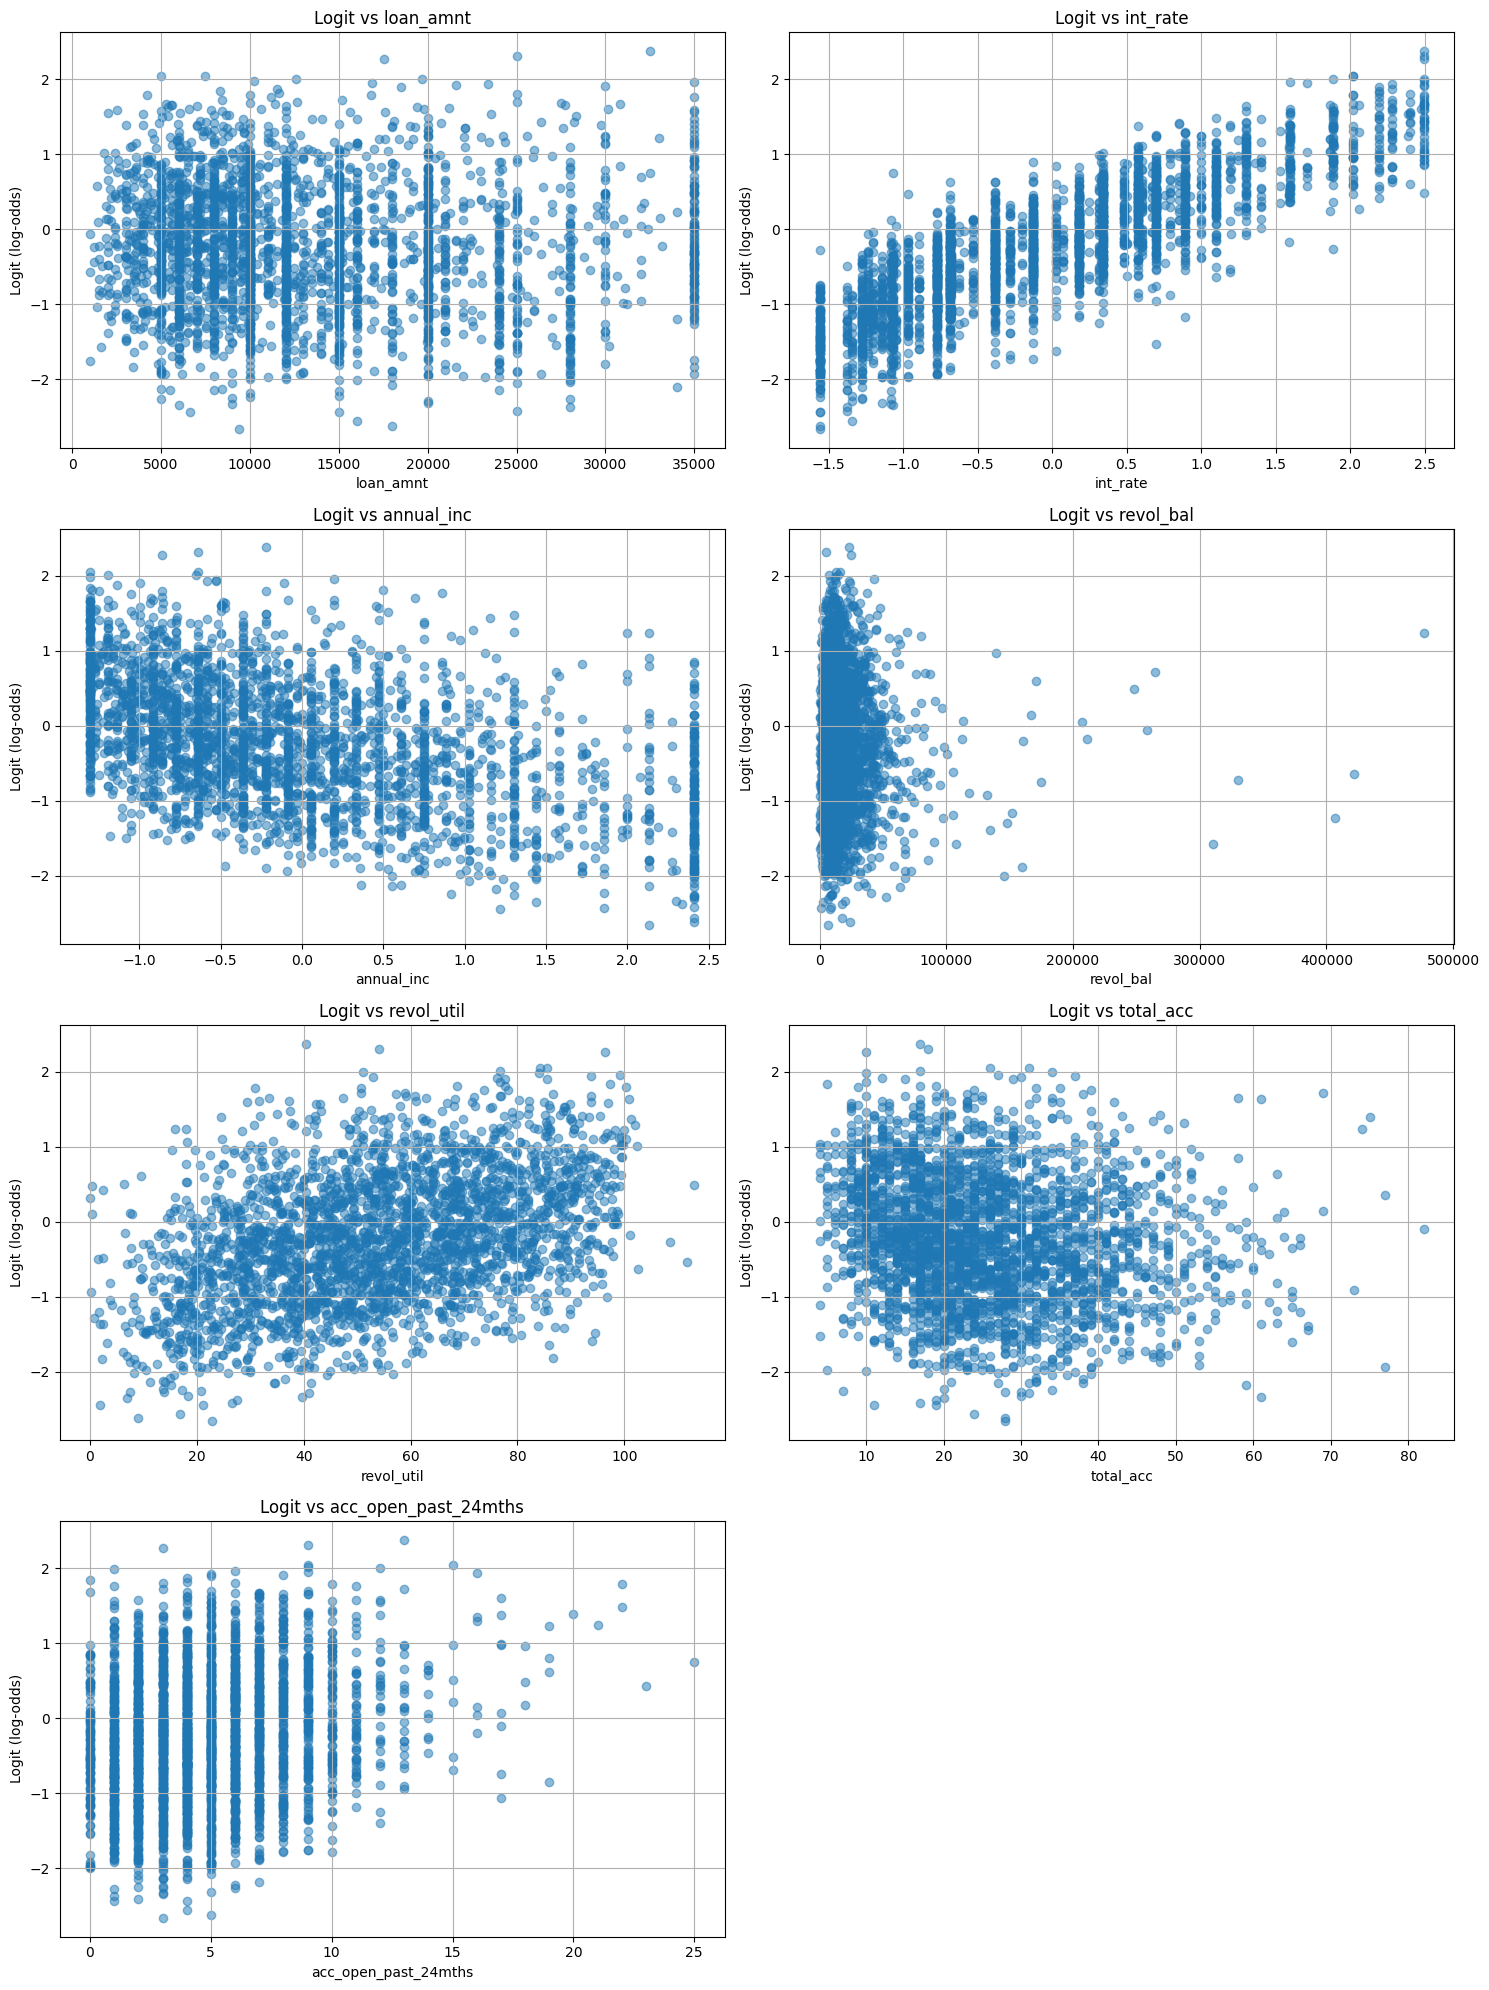

In [44]:
#Import library
import matplotlib.pyplot as plt

#Evaluate linearity between continuous variables
continuous_vars = ['loan_amnt', 'int_rate', 'annual_inc',
                   'revol_bal', 'revol_util', 'total_acc', 'acc_open_past_24mths']

'''
The feature 'installment' was removed from the model due to multicollinearity concerns. T
The Variance Inflation Factor (VIF) analysis indicated a very high VIF value for 'installment', 
suggesting it is highly correlated with other variables in the dataset. 
Additionally, exploratory data analysis, including scatterplots and correlation matrices, 
confirmed strong redundancy with related features such as 'loan_amnt'. 
Removing 'installment' helps improve model stability and interpretability without significant loss of information.

'''

# Create logit values
logit = np.log(y_pred_prob/ (1 - y_pred_prob))

# Plot each variable against the logit
plt.figure(figsize=(15, 20))

for i, var in enumerate(continuous_vars):
    plt.subplot(4, 2, i + 1)
    plt.scatter(X_test[var], logit, alpha=0.5)
    plt.title(f'Logit vs {var}')
    plt.xlabel(var)
    plt.ylabel('Logit (log-odds)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
#Import libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Evaluate multicollinearity using VIF
X_vif = X[continuous_vars]

# Add constant for VIF calculation
X_vif = add_constant(X_vif)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))

                Feature        VIF
0                 const  19.956931
3            annual_inc   1.765489
1             loan_amnt   1.619354
7  acc_open_past_24mths   1.538082
6             total_acc   1.419684
2              int_rate   1.387181
5            revol_util   1.298691
4             revol_bal   1.287115


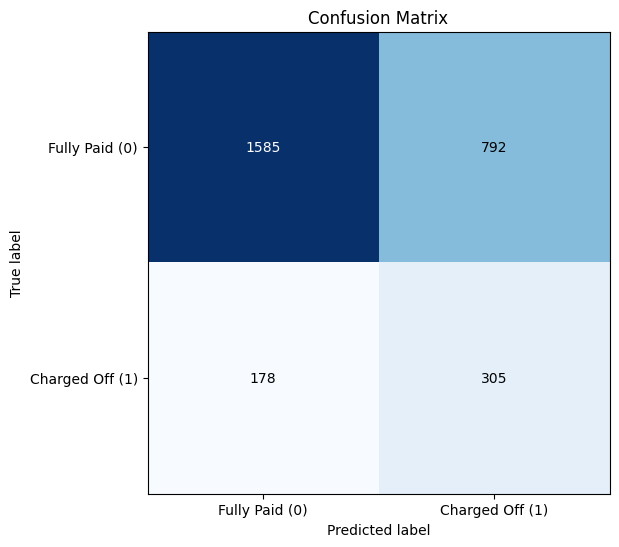

In [45]:
#Import libraries
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

#Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(cm, cmap='Blues')

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['Fully Paid (0)', 'Charged Off (1)'])
ax.set_yticklabels(['Fully Paid (0)', 'Charged Off (1)'])

#Loop to annotate each cell with counts
for i in range(2):
    for j in range(2):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

plt.show()

In [46]:
#Import libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: ", round(accuracy,4))
print("Precision: ", round(precision, 4))
print("Recall: ", round(recall, 4))
print("f1_score: ", round(f1, 4))

Accuracy:  0.6608
Precision:  0.278
Recall:  0.6315
f1_score:  0.3861


In [47]:
#Import library
from sklearn.metrics import roc_auc_score

#Calculate metric
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Roc_auc_score : ", round(roc_auc, 4))

Roc_auc_score :  0.7026


## Part 1 - Classification Tree Model

In [48]:
#Import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#Initialize
tree = DecisionTreeClassifier(random_state = 12345)

#Define parameter grid
param_grid = {'max_depth': [4, 6, 8, 10],
              'min_samples_split': [2, 10, 20],
              'min_samples_leaf': [1, 5, 10],
              'criterion': ['gini', 'entropy'],
              'class_weight': ['balanced']}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model
best_tree = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [49]:
#Model training with best parameters
best_tree = DecisionTreeClassifier(class_weight='balanced',
                                   criterion='gini',
                                   max_depth=4,
                                   min_samples_leaf=5,
                                   min_samples_split=2,
                                   random_state=123)

best_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=5,
                       random_state=123)

In [50]:
#Predict on testing set
y_pred = best_tree.predict(X_test)
y_pred_prob = best_tree.predict_proba(X_test)[:, 1]

In [51]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[1662  715]
 [ 230  253]]


In [52]:
#Classification metrics and roc_auc_score
print("Classification Report: ")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC Score:", round(roc_auc, 4))

Classification Report: 
              precision    recall  f1-score   support

           0     0.8784    0.6992    0.7786      2377
           1     0.2614    0.5238    0.3487       483

    accuracy                         0.6696      2860
   macro avg     0.5699    0.6115    0.5637      2860
weighted avg     0.7742    0.6696    0.7060      2860

ROC_AUC Score: 0.6633


In [53]:
#Variable importance
feat_importances = pd.Series(best_tree.feature_importances_, index=X_train.columns)
print(feat_importances.sort_values(ascending=False))

int_rate                               0.696846
annual_inc                             0.135313
revol_bal                              0.077808
revol_util                             0.074653
home_ownership_RENT                    0.015381
loan_amnt                              0.000000
installment                            0.000000
total_acc                              0.000000
acc_open_past_24mths                   0.000000
home_ownership_OWN                     0.000000
verification_status_Source Verified    0.000000
verification_status_Verified           0.000000
dtype: float64


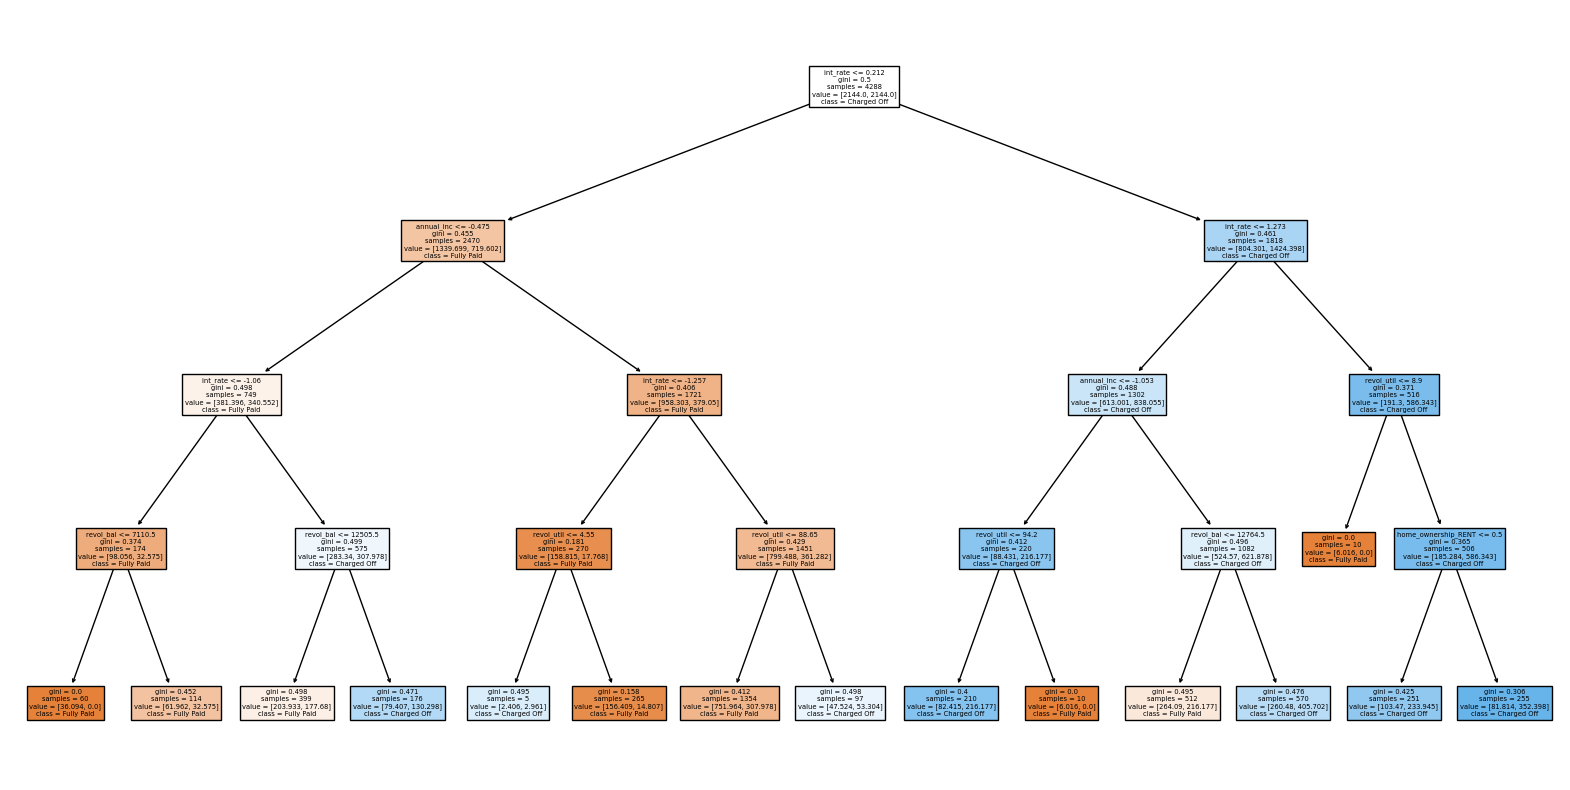

In [54]:
#Import library
from sklearn.tree import plot_tree

#Visualize tree
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=X_train.columns, class_names=['Fully Paid', 'Charged Off'], filled=True)
plt.show()

## Part 1 - Neural Network Model

In [71]:
#Import library
from sklearn.neural_network import MLPClassifier

#Initialize
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=12345)

#Fit
mlp.fit(X_train, y_train)

#Predict
y_pred_prob = mlp.predict_proba(X_test)[:, 1]
y_pred = mlp.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_pred_prob), 4))

Accuracy: 0.7734
ROC AUC: 0.5538


In [72]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[2129  248]
 [ 400   83]]


In [82]:
from sklearn.model_selection import RandomizedSearchCV

#Manual oversampling of minority class (label = 1)
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

n_samples_to_add = len(y_train_0) - len(y_train_1)
indices = np.random.choice(X_train_1.index, size=n_samples_to_add, replace=True)

X_train_1_oversampled = X_train_1.loc[indices]
y_train_1_oversampled = y_train_1.loc[indices]

X_train_balanced = pd.concat([X_train_0, X_train_1, X_train_1_oversampled])
y_train_balanced = pd.concat([y_train_0, y_train_1, y_train_1_oversampled])

#Shuffle the balanced training data
shuffled_indices = np.random.permutation(len(y_train_balanced))
X_train_balanced = X_train_balanced.iloc[shuffled_indices]
y_train_balanced = y_train_balanced.iloc[shuffled_indices]

#Initialize the base MLPClassifier model
mlp = MLPClassifier(random_state=12345, max_iter=1000)

#Define hyperparameter distribution for randomized search
param_dist = {'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50, 25)],
              'activation': ['relu', 'tanh'],
              'alpha': [0.0001, 0.001, 0.01],
              'learning_rate_init': [0.001, 0.01, 0.1],
              'solver': ['adam']}

#Set up randomized search with 20 iterations and 3-fold cross-validation
random_search = RandomizedSearchCV(mlp,
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   scoring='roc_auc',
                                   cv=3,
                                   random_state=12345,
                                   n_jobs=-1)

#Fit the model on the balanced training data
random_search.fit(X_train_balanced, y_train_balanced)

print("Best hyperparameters found:", random_search.best_params_)

#Evaluate the best model on the original test set
best_model = random_search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Best hyperparameters found: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'alpha': 0.01, 'activation': 'relu'}
Accuracy: 0.5374
ROC AUC: 0.6481


In [83]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[1196 1181]
 [ 142  341]]
